In [227]:
#!/usr/bin/env python3
"""
Example usage of the system_prop_lens_prop optical system.

This demonstrates how to create and use an optical system that:
1. Creates a Gaussian plane wave source
2. Propagates it by distance z1
3. Applies a thin lens with focal length f
4. Propagates it by distance z2
"""

import numpy as np
import jax.numpy as jnp
from chromatix.systems import system_prop_lens_prop
from chromatix.elements.sources import GaussianPlaneWave, PlaneWave
from chromatix.elements import Propagate, ThinLens
import matplotlib.pyplot as plt 
import chromatix.functional as cf

from chromatix.systems import OpticalSystem


In [228]:
def system_prop_lens_prop(
    shape: tuple[int, int],
    dx: float,
    spectrum: float,
    spectral_density: float = 1.0,
    waist: float = 1e-3,
    z1: float = 1e-3,
    z2: float = 1e-3,
    f: float = 1e-3,
    n: float = 1.0,
    power: float = 1.0,
    NA: float | None = None,
) -> OpticalSystem:
    """
    Creates an optical system with Gaussian source -> propagate -> lens -> propagate.
    
    This system:
    1. Creates a Gaussian plane wave source
    2. Propagates it by distance z1
    3. Applies a thin lens with focal length f
    4. Propagates it by distance z2
    
    Args:
        shape: The shape (height, width) of the field grid.
        dx: The spatial sampling interval.
        spectrum: The wavelength(s) to simulate.
        spectral_density: The spectral weight(s). Defaults to 1.0.
        waist: The waist size of the Gaussian beam. Defaults to 1e-3.
        z1: First propagation distance (before lens). Defaults to 1e-3.
        z2: Second propagation distance (after lens). Defaults to 1e-3.
        f: Focal length of the lens. Defaults to 1e-3.
        n: Refractive index of the medium. Defaults to 1.0.
        power: Total power of the source. Defaults to 1.0.
        NA: Numerical aperture of the lens. If None, no pupil is applied.
        
    Returns:
        OpticalSystem: The configured optical system.
    """
    
    return OpticalSystem(
        elements=[
            GaussianPlaneWave(
                shape=shape,
                dx=dx,
                spectrum=spectrum,
                spectral_density=spectral_density,
                waist=waist,
                power=power,
            ),
            Propagate(z=z1, n=n),
            ThinLens(f=f, n=n, NA=NA),
            Propagate(z=z2, n=n),
        ]
    )

In [229]:
# Define system parameters
shape = (256, 256)  # Field grid size
dx = 1e-6  # 1 micron pixel spacing
spectrum = 632.8e-9  # Red laser wavelength (HeNe)
spectral_density = 1.0
waist = 50e-6  # 50 micron beam waist
z1 = 1e-3  # 1 mm propagation before lens
z2 = 1e-3  # 1 mm propagation after lens
f = 5e-3  # 5 mm focal length lens
n = 1.0  # Air
power = 1.0
NA = 0.5  # Numerical aperture

# Create the optical system
optical_system = system_prop_lens_prop(
    shape=shape,
    dx=dx,
    spectrum=spectrum,
    spectral_density=spectral_density,
    waist=waist,
    z1=z1,
    z2=z2,
    f=f,
    n=n,
    power=power,
    NA=NA
)


In [230]:
# Initialize the system (this is required for JAX/Flax modules)
import jax
key = jax.random.PRNGKey(0)
params = optical_system.init(key)

# Run the optical system
output_field = optical_system.apply(params)

In [231]:
def loss_intensity(output_field, input_light):
    return jnp.sum(jnp.abs(output_field.intensity - input_light.intensity)**2)

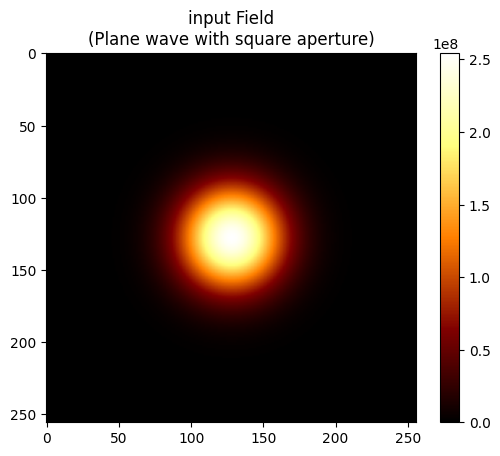

0.0


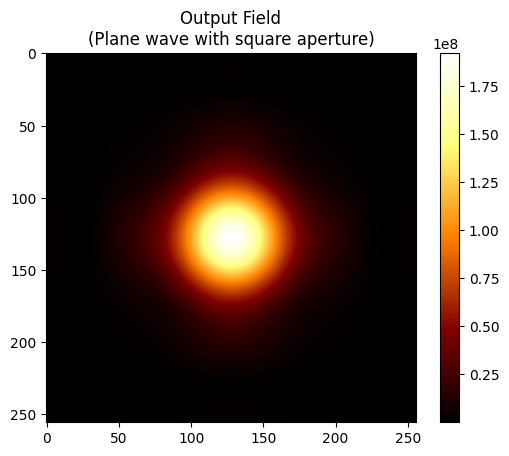

0.001


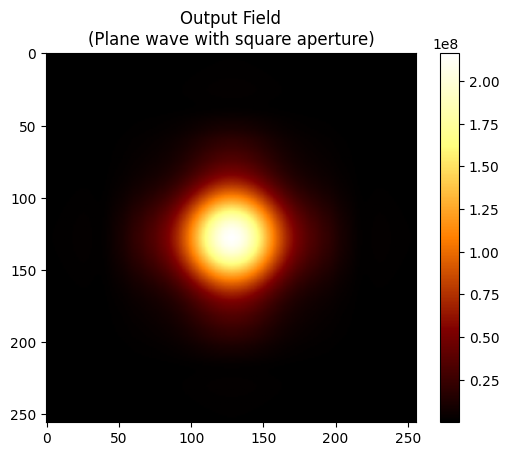

0.002


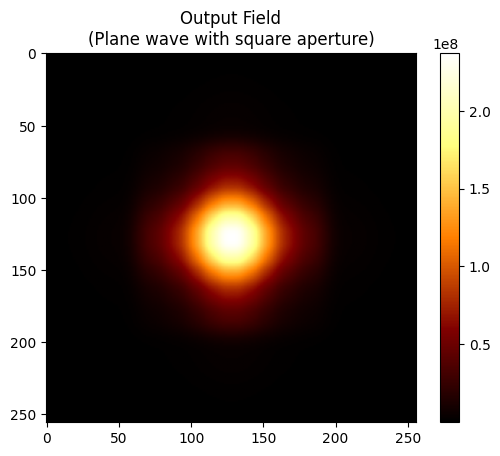

0.003


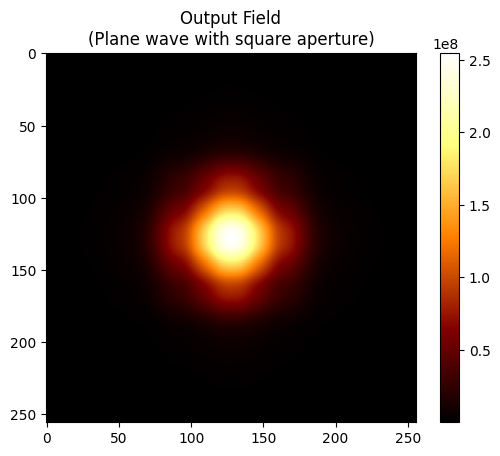

0.004


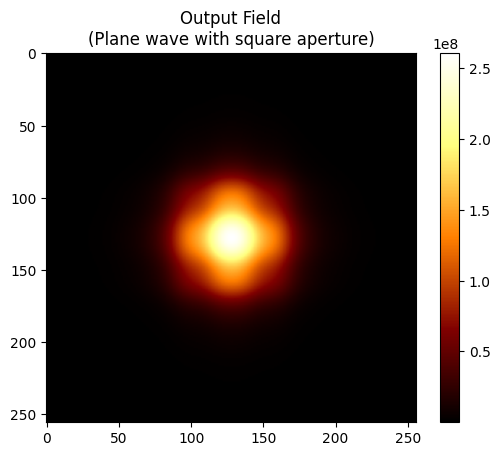

0.005


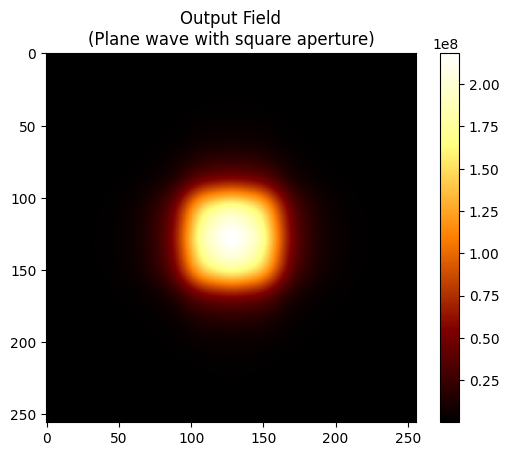

0.006


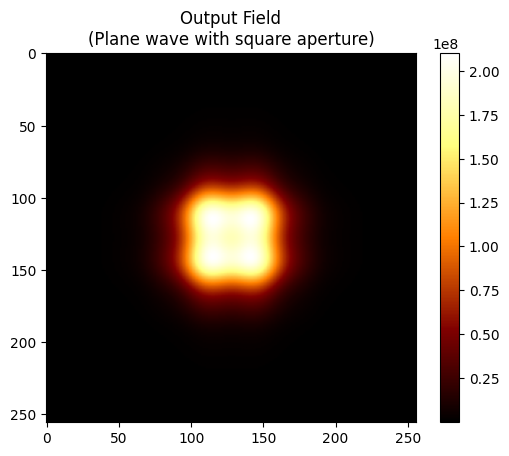

0.007


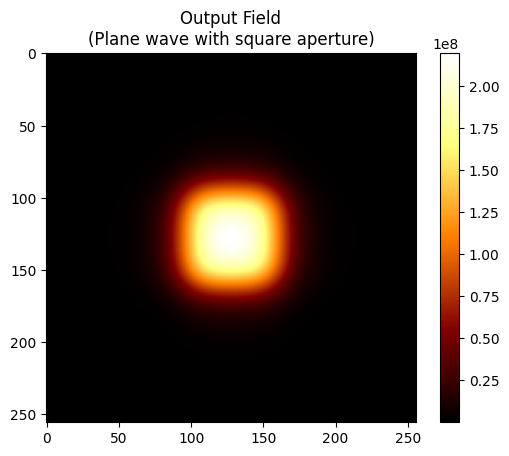

0.008


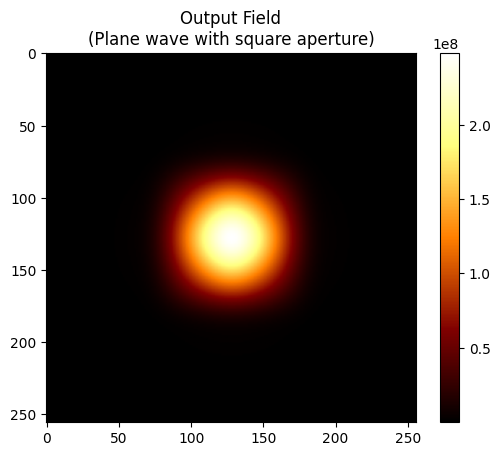

0.009000000000000001
0.01


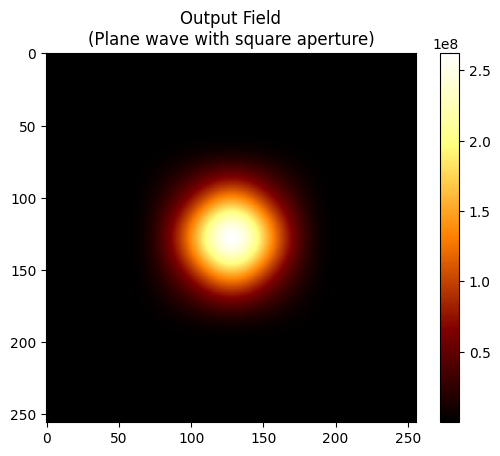

0.011
0.012


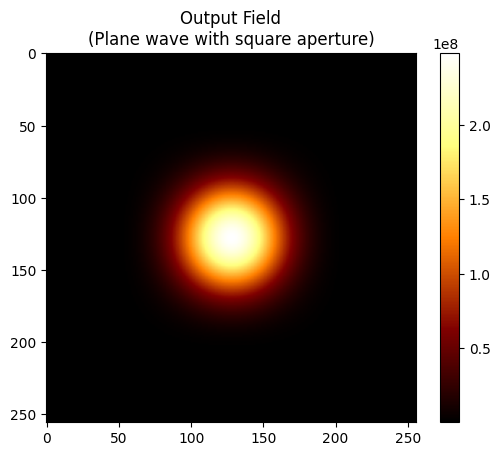

0.013000000000000001
0.014


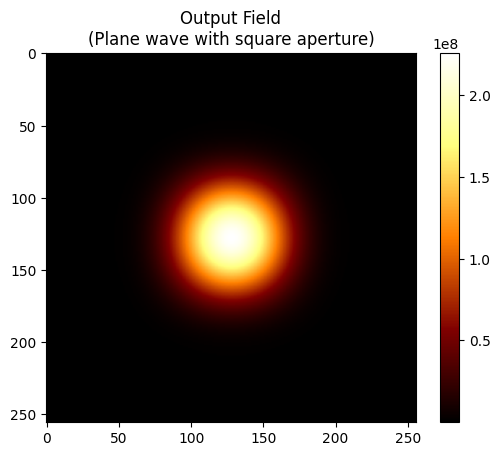

0.015
0.016


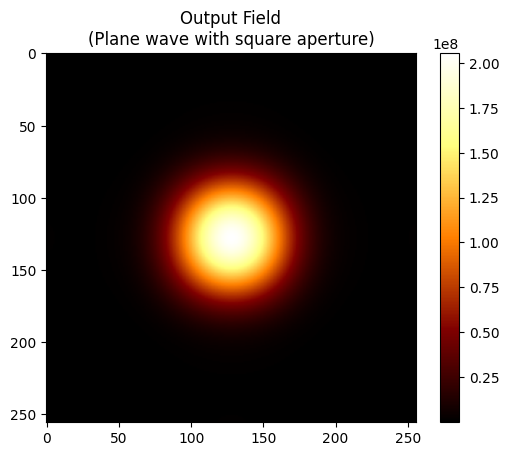

0.017
0.018000000000000002
0.019


In [232]:
input_light = cf.gaussian_plane_wave(
    shape=shape,
    dx=dx,
    spectrum=spectrum,
    spectral_density=spectral_density,
    power=power,
    waist=waist
)

plt.imshow(input_light.intensity.squeeze(), cmap='afmhot')
plt.title('input Field\n(Plane wave with square aperture)')
plt.colorbar()
plt.axis('on')
plt.show()

losses = []
lengths = []

max_step=20e-3
step_size=1e-4

for i in np.arange(0, max_step, step_size):

    optical_system = OpticalSystem(
        elements=[
            GaussianPlaneWave(
                shape=shape,
                dx=dx,
                spectrum=spectrum,
                spectral_density=spectral_density,
                power=power,
                waist=waist
            ),
            Propagate(z=10e-3, n=n),
            ThinLens(f=10e-3, n=n, NA=NA),
            Propagate(z=20e-3, n=n),
            ThinLens(f=10e-3, n=n, NA=NA),
            Propagate(z=i, n=n)
        ])
    
    '''system_prop_lens_prop(
        shape=shape,
        dx=dx,
        spectrum=spectrum,
        spectral_density=spectral_density,
        waist=waist,
        z1=10e-3,
        z2=i,
        f=10e-3,
        n=n,
        power=power,
        NA=1
    )'''


    key = jax.random.PRNGKey(0)
    params = optical_system.init(key)

    # Run the optical system
    output_field = optical_system.apply(params)

    print(i)

    if i % step_size*10 == 0:

        field_diff = output_field.intensity - input_light.intensity
        
        '''plt.imshow(field_diff.squeeze(), cmap='afmhot')
        plt.title('Output Field\n(Plane wave with square aperture)')
        plt.colorbar()
        plt.axis('on')
        plt.show()'''

        plt.imshow(output_field.intensity.squeeze(), cmap='afmhot')
        plt.title('Output Field\n(Plane wave with square aperture)')
        plt.colorbar()
        plt.axis('on')
        plt.show()


    

    losses.append(loss_intensity(output_field, input_light))
    lengths.append(i)


    

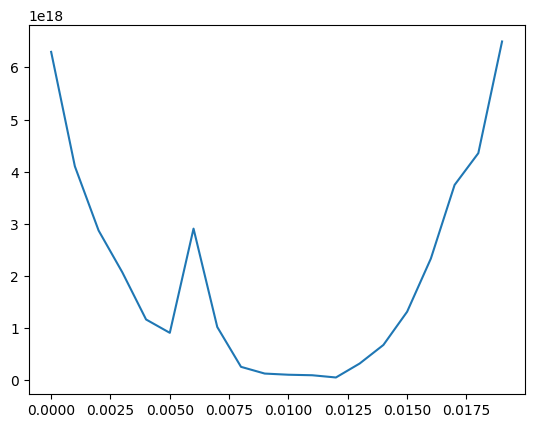

In [233]:
plt.plot(lengths, losses)
plt.show()